In [1]:
%%capture --no-display
!pip install jupyterlab_execute_time

In [2]:
import npu

# vector length; must be divisible by 4
vector_size = 128

Create app builder

In [3]:
from npu.build.kernel import Kernel
from npu.build.appbuilder import AppBuilder
import numpy as np
from npu.build.itkernel import ITWrite
from npu.build.mtkernel import MTSplit, MTConcat
from vector_add import VectorAddVecP

class SimpleApplication(AppBuilder):

    def __init__(self):
        self.kernel = [VectorAddVecP() for _ in range(4)]
        self.mtbsplit = MTSplit(4)
        self.mtbconcat = MTConcat()
        super().__init__()

    def callgraph(self, x_in1: np.ndarray, x_in2: np.ndarray, x_out: np.ndarray) -> None:
        nbytes = x_in1.shape[0]

        kernel_outputs = [None] * 4

        inputs1 = self.mtbsplit(x_in1)
        inputs2 = self.mtbsplit(x_in2)

        for i in range(4):
            kernel_outputs[i] = self.kernel[i](inputs1[i], inputs2[i], int(nbytes/4))

        mtbuffer_out = self.mtbconcat(kernel_outputs)
        
        _ = ITWrite(mtbuffer_out, bufref=x_out)

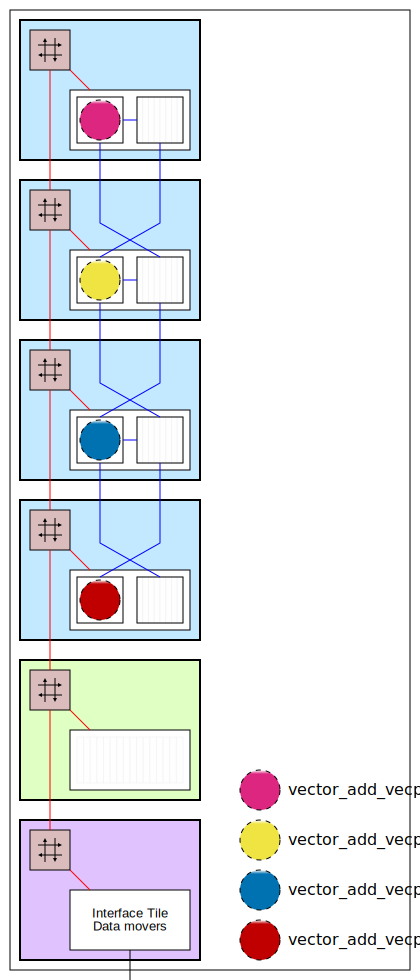

In [4]:
app_builder = SimpleApplication()

x_in1 = np.zeros(shape=(vector_size), dtype=np.uint8)
x_in2 = np.zeros(shape=(vector_size), dtype=np.uint8)
x_out = np.zeros(shape=(vector_size), dtype=np.uint8)

app_builder(x_in1, x_in2, x_out)

app_builder.display()
app_builder.save()

Build the app

In [5]:
app_builder.build(x_in1, x_in2, x_out)

Using cached vector_add_vecp kernel object file...
Building the xclbin...
ERROR! WSL failed 

cp: cannot stat '/mnt/c/Users/EE451/AppData/Local/Temp/pnx6h8um82e/build_template/final.xclbin': No such file or directory



CalledProcessError: Command '['wsl', '-d', 'Riallto', 'cp', '/mnt/c/Users/EE451/AppData/Local/Temp/pnx6h8um82e/build_template/final.xclbin', './SimpleApplication.xclbin']' returned non-zero exit status 1.

In [ ]:
app_builder.metadata

Prep AppRunner and data

In [ ]:
from npu.runtime import AppRunner

app = AppRunner('SimpleApplication.xclbin')

# Allocate app input and output buffers to exchange data with NPU
input1_vector = app.allocate(shape=(vector_size))
input2_vector = app.allocate(shape=(vector_size))
output_vector = app.allocate(shape=(vector_size))

# Load data
input1_array = np.zeros(vector_size, dtype=np.uint8)
input2_array = np.zeros(vector_size, dtype=np.uint8)
for i in range(vector_size):
    input1_array[i] = 1
    input2_array[i] = 2

input1_vector[:] = input1_array
input2_vector[:] = input2_array

Run the application

In [ ]:
# Pass input_vector buffer to NPU
input1_vector.sync_to_npu()
input2_vector.sync_to_npu()

# Run app on NPU
app.call(input1_vector, input2_vector, output_vector)

# Get results from NPU via output_vector buffer 
output_vector.sync_from_npu()

In [ ]:
# Verify output
print(input1_vector)
print(input2_vector)
print(output_vector)

In [ ]:
del app